In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Specify filepaths.

retrain_db = "/gscratch/cse/clin25/diffusion-attr/seed42/artbench_post_impressionism/retrain_artist_shapley.jsonl"
retrain_dir = "/gscratch/cse/clin25/diffusion-attr/seed42/artbench_post_impressionism/retrain/models/artist_shapley"

# GD with 200 steps.
gd_db = "/gscratch/scrubbed/clin25/diffusion-attr/seed42/artbench_post_impressionism/gd_artist_shapley.jsonl"
gd_dir = "/gscratch/scrubbed/clin25/diffusion-attr/seed42/artbench_post_impressionism/gd/models/artist_shapley"

In [3]:
# Obtain training time, inference time, and total time for retraining-based Shapley,
# for 1000 subsets.

retrain_df = pd.read_json(retrain_db, lines=True)
retrain_df["shapley_seed"] = (
    retrain_df["exp_name"]
    .str.split("/", expand=True)[4]
    .str.split("shapley_seed_", expand=True)[1]
    .astype(int)
)
retrain_df = retrain_df.sort_values(by="shapley_seed")
retrain_inference_time_list = retrain_df["aesthetic_score_time"].tolist()
retrain_training_time_list = []
for shapley_seed in retrain_df["shapley_seed"].tolist():
    training_time_df = pd.read_csv(os.path.join(retrain_dir, f"shapley_seed={shapley_seed}", "time.csv"))
    training_time_df = training_time_df.drop_duplicates(subset="epoch")
    retrain_training_time_list.append(training_time_df["time"].sum())

retrain_total_time_list = [
    retrain_training_time_list[i] + retrain_inference_time_list[i]
    for i in range(len(retrain_inference_time_list))
]

In [4]:
# Obtain training time, inference time, and total time for GD-based Shapley,
# for 1000 subsets.

gd_df = pd.read_json(gd_db, lines=True)
gd_df["shapley_seed"] = (
    gd_df["exp_name"]
    .str.split("/", expand=True)[4]
    .str.split("shapley_seed_", expand=True)[1]
    .astype(int)
)
gd_df = gd_df.sort_values(by="shapley_seed")
gd_inference_time_list = gd_df["aesthetic_score_time"].tolist()
gd_training_time_list = []
for shapley_seed in gd_df["shapley_seed"].tolist():
    training_time_df = pd.read_csv(os.path.join(gd_dir, f"shapley_seed={shapley_seed}", "time.csv"))
    training_time_df = training_time_df.drop_duplicates(subset="step")
    gd_training_time_list.append(training_time_df["time"].sum())

gd_total_time_list = [
    gd_training_time_list[i] + gd_inference_time_list[i]
    for i in range(len(gd_inference_time_list))
]

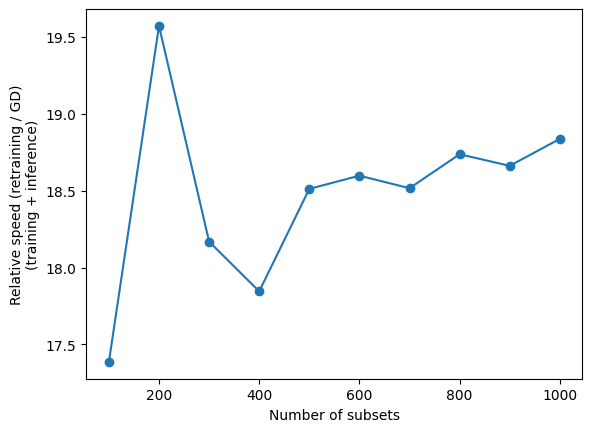

In [5]:
# Visualize the number of subsets needed to get a consistent estimate for the runtime ratio.
num_subsets_list = [i * 100 for i in range(1, 11)]
total_time_ratio_list = []

for num_subsets in num_subsets_list:
    ratio = np.mean(retrain_total_time_list[:num_subsets]) / np.mean(gd_total_time_list[:num_subsets])
    total_time_ratio_list.append(ratio)

plt.plot(num_subsets_list, total_time_ratio_list, marker="o", color="tab:blue")
plt.xlabel("Number of subsets")
plt.ylabel("Relative speed (retraining / GD)\n(training + inference)")
plt.show()

In [6]:
# Estimate based on 500 subsets.
num_subsets = 500
retrain_training_time = np.mean(retrain_training_time_list[:num_subsets])
retrain_inference_time = np.mean(retrain_inference_time_list[:num_subsets])

gd_training_time = np.mean(gd_training_time_list[:num_subsets])
gd_inference_time = np.mean(gd_inference_time_list[:num_subsets])

print("Retraining")
print(f"  Training time: {retrain_training_time}")
print(f"  Inference time: {retrain_inference_time}")
print(f"  Total time: {retrain_training_time + retrain_inference_time}")

print("")
print("GD")
print(f"  Training time: {gd_training_time}")
print(f"  Inference time: {gd_inference_time}")
print(f"  Total time: {gd_training_time + gd_inference_time}")

print("")
gd_speed = (retrain_training_time + retrain_inference_time) / (gd_training_time + gd_inference_time)
print(f"Retraining/GD speed up: {gd_speed}")

Retraining
  Training time: 11433.81446191792
  Inference time: 383.4250876555443
  Total time: 11817.239549573464

GD
  Training time: 264.8521475091
  Inference time: 373.50121590042113
  Total time: 638.3533634095211

Retraining/GD speed up: 18.512065929215417
